LM: cost = 199.474, iters = 1, time = 0.000s, params = [ 1.          0.19753772 -3.01        1.99999   ]
SA: cost = 236.526, iters = 1, time = 0.000s, params = [ 0.9878402  0.        -3.01       1.99999  ]
DE: cost = 171.997, iters = 12, time = 0.024s, params = [ 0.45119612  0.78997035 -2.99        1.99999   ]
PSO: cost = 171.981, iters = 95, time = 0.061s, params = [ 0.42038455  0.81042545 -2.99        1.99999   ]
NM: cost = 236.499, iters = 8, time = 0.000s, params = [ 1.       0.      -2.99     1.99999]


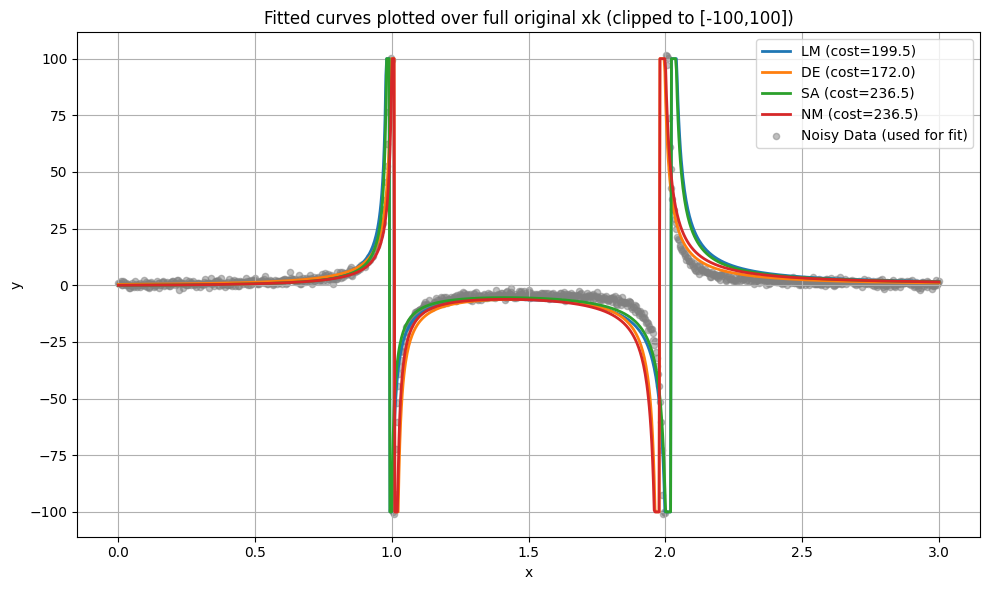


Summary Table:
Method         Cost      Iters Time (s)
LM           199.47          1    0.000
SA           236.53          1    0.000
DE           172.00         12    0.024
NM           236.50          8    0.000


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)
K = 1000
xk_full = (3.0 * np.arange(K + 1)) / 1000.0  # keep the original full xk

def f_true(x):
    return 1.0 / (x**2 - 3*x + 2)

delta = 1 * np.random.normal(loc=0.0, scale=1, size=xk_full.shape)

fk = f_true(xk_full)
yk_full = np.empty_like(fk)
yk_full[fk < -100.0] = -100.0 + delta[fk < -100.0]
mask_mid = (fk >= -100.0) & (fk <= 100.0)
yk_full[mask_mid] = fk[mask_mid] + delta[mask_mid]
yk_full[fk > 100.0] = 100.0 + delta[fk > 100.0]


xk = xk_full[:200]
yk = yk_full[:200]

def F(x, p):
    a, b, c, d = p
    B = x**2 + c*x + d
    eps = 1e-12
    B_safe = np.where(np.abs(B) < eps, np.sign(B)*eps + eps, B)
    return (a*x + b) / B_safe

def residuals(p):
    return F(xk, p) - yk

def objective(p):
    r = residuals(p)
    return float(np.sum(r*r))

def jacobian(p):
    a, b, c, d = p
    A = a*xk + b
    B = xk**2 + c*xk + d
    eps = 1e-12
    B_safe = np.where(np.abs(B) < eps, np.sign(B)*eps + eps, B)
    B2 = B_safe * B_safe
    J = np.empty((xk.size, 4))
    J[:, 0] = xk / B_safe
    J[:, 1] = 1.0 / B_safe
    J[:, 2] = - (A * xk) / B2
    J[:, 3] = - A / B2
    return J

def clip_params(p, lb, ub):
    return np.minimum(np.maximum(p, lb), ub)

bounds = np.array([[-1, 1], [0, 2], [-3-1e-2,-3+1e-2], [2-1e-5, 2-1e-5]])
lb = bounds[:,0]
ub = bounds[:,1]

def levenberg_marquardt(p0, eps=1e-3, max_iter=1000, lambda0=1e-3):
    p = p0.astype(float).copy()
    lam = float(lambda0)
    prev_cost = objective(p)
    for it in range(1, max_iter + 1):
        r = residuals(p)
        J = jacobian(p)
        A = J.T.dot(J)
        g = J.T.dot(r)
        diagA = np.diag(np.diag(A))
        lhs = A + lam * diagA + 1e-16 * np.eye(A.shape[0])
        try:
            delta = np.linalg.solve(lhs, -g)
        except np.linalg.LinAlgError:
            break
        p_candidate = clip_params(p + delta, lb, ub)
        cost_candidate = objective(p_candidate)
        if cost_candidate < prev_cost:
            p = p_candidate
            prev_cost = cost_candidate
            lam = max(lam * 0.8, 1e-12)
        else:
            lam *= 2.0
        rel_change = abs(prev_cost - cost_candidate) / (prev_cost + 1e-20)
        if rel_change < eps:
            return p, prev_cost, it
    return p, prev_cost, max_iter

def simulated_annealing(p0, obj_fn, eps=1e-3, max_iter=1000,
                        T0=1e4, alpha=0.95, scale=0.05, lb=None, ub=None):
    p = p0.astype(float).copy()
    cost = obj_fn(p)
    best_p = p.copy()
    best_cost = cost
    T = float(T0)
    for it in range(1, max_iter + 1):
        step = np.random.normal(loc=0.0, scale=1.0, size=p.shape) * (scale * (np.abs(p) + 1.0))
        candidate = clip_params(p + step, lb, ub)
        cand_cost = obj_fn(candidate)
        dE = cand_cost - cost
        if dE < 0.0 or np.random.rand() < np.exp(-dE / (T + 1e-16)):
            p = candidate
            cost = cand_cost
            if cost < best_cost:
                best_cost = cost
                best_p = p.copy()
        T *= alpha
        rel_change = abs(best_cost - cost) / (best_cost + 1e-20)
        if rel_change < eps:
            return best_p, best_cost, it
    return best_p, best_cost, max_iter

def differential_evolution(obj_fn, dim, bounds, pop_size=40, F=0.7, CR=0.9, eps=1e-3, max_iter=1000):
    lb = np.array([b[0] for b in bounds])
    ub = np.array([b[1] for b in bounds])
    pop = lb + (ub - lb) * np.random.rand(pop_size, dim)
    pop_cost = np.array([obj_fn(ind) for ind in pop])
    best_idx = int(np.argmin(pop_cost))
    best = pop[best_idx].copy()
    best_cost = float(pop_cost[best_idx])
    for it in range(1, max_iter + 1):
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            r1, r2, r3 = np.random.choice(idxs, 3, replace=False)
            mutant = pop[r1] + F * (pop[r2] - pop[r3])
            cross = np.random.rand(dim) < CR
            jrand = np.random.randint(dim)
            cross[jrand] = True
            trial = np.where(cross, mutant, pop[i])
            trial = clip_params(trial, lb, ub)
            trial_cost = obj_fn(trial)
            if trial_cost < pop_cost[i]:
                pop[i] = trial
                pop_cost[i] = trial_cost
                if trial_cost < best_cost:
                    best_cost = float(trial_cost)
                    best = trial.copy()
        if np.std(pop_cost) / (np.mean(pop_cost) + 1e-20) < eps:
            return best, best_cost, it
    return best, best_cost, max_iter

def particle_swarm(obj_fn, dim, bounds, swarm_size=40, w=0.7, c1=1.5, c2=1.5, eps=1e-3, max_iter=1000):
    lb = np.array([b[0] for b in bounds])
    ub = np.array([b[1] for b in bounds])
    X = lb + (ub - lb) * np.random.rand(swarm_size, dim)
    V = np.zeros_like(X)
    pbest = X.copy()
    pbest_cost = np.array([obj_fn(x) for x in X])
    gbest_idx = int(np.argmin(pbest_cost))
    gbest = pbest[gbest_idx].copy()
    gbest_cost = float(pbest_cost[gbest_idx])
    vmax = 0.2 * (ub - lb)
    vmin = -vmax
    for it in range(1, max_iter + 1):
        r1 = np.random.rand(swarm_size, dim)
        r2 = np.random.rand(swarm_size, dim)
        V = w*V + c1*r1*(pbest - X) + c2*r2*(gbest - X)
        V = np.minimum(np.maximum(V, vmin), vmax)
        X = np.minimum(np.maximum(X + V, lb), ub)
        costs = np.array([obj_fn(x) for x in X])
        improved = costs < pbest_cost
        pbest[improved] = X[improved]
        pbest_cost[improved] = costs[improved]
        idx_min = int(np.argmin(pbest_cost))
        if pbest_cost[idx_min] < gbest_cost:
            gbest_cost = float(pbest_cost[idx_min])
            gbest = pbest[idx_min].copy()
        if np.linalg.norm(V) < 1e-3:
            return gbest, gbest_cost, it
    return gbest, gbest_cost, max_iter

def nelder_mead(obj_fn, x0, tol=1e-6, max_iter=1000,
                rho=1.0, chi=2.0, gamma=0.5, sigma=0.5,
                initial_simplex=None, lb=None, ub=None, callback=None):
    x0 = np.asarray(x0, dtype=float).ravel()
    n = x0.size

    if initial_simplex is not None:
        simp = np.asarray(initial_simplex, dtype=float).reshape((n + 1, n)).copy()
    else:
        simp = np.zeros((n + 1, n))
        simp[0] = x0
        for i in range(n):
            y = x0.copy()
            y[i] = y[i] + (0.05 if y[i] == 0 else 0.05 * abs(y[i]))
            simp[i + 1] = y

    if lb is not None or ub is not None:
        lb_a = np.full(n, -np.inf) if lb is None else np.asarray(lb, dtype=float).ravel()
        ub_a = np.full(n, np.inf) if ub is None else np.asarray(ub, dtype=float).ravel()
        simp = np.minimum(np.maximum(simp, lb_a), ub_a)
    else:
        lb_a = None
        ub_a = None

    costs = np.array([obj_fn(s) for s in simp])
    it = 0
    while it < max_iter:
        idx = np.argsort(costs)
        simp = simp[idx]
        costs = costs[idx]

        if np.std(costs) <= tol and np.ptp(simp, axis=0).max() <= tol:
            break

        x_bar = np.mean(simp[:n], axis=0)

        x_r = x_bar + rho * (x_bar - simp[-1])
        if lb_a is not None:
            x_r = np.minimum(np.maximum(x_r, lb_a), ub_a)
        f_r = obj_fn(x_r)

        if f_r < costs[0]:
            x_e = x_bar + chi * (x_r - x_bar)
            if lb_a is not None:
                x_e = np.minimum(np.maximum(x_e, lb_a), ub_a)
            f_e = obj_fn(x_e)
            if f_e < f_r:
                simp[-1] = x_e
                costs[-1] = f_e
            else:
                simp[-1] = x_r
                costs[-1] = f_r
        elif f_r < costs[-2]:
            simp[-1] = x_r
            costs[-1] = f_r
        else:
            if f_r < costs[-1]:
                x_c = x_bar + gamma * (x_r - x_bar)
            else:
                x_c = x_bar - gamma * (x_bar - simp[-1])
            if lb_a is not None:
                x_c = np.minimum(np.maximum(x_c, lb_a), ub_a)
            f_c = obj_fn(x_c)
            if f_c < costs[-1]:
                simp[-1] = x_c
                costs[-1] = f_c
            else:
                for j in range(1, n + 1):
                    simp[j] = simp[0] + sigma * (simp[j] - simp[0])
                    if lb_a is not None:
                        simp[j] = np.minimum(np.maximum(simp[j], lb_a), ub_a)
                    costs[j] = obj_fn(simp[j])

        it += 1
        if callback is not None:
            callback(simp, costs)

    best_idx = int(np.argmin(costs))
    return simp[best_idx].copy(), float(costs[best_idx]), it


p0 = np.array([0.9, -0.9, -2.9, 1.9])
p0lm = p0
psa = p0


t0 = time.time()
p_lm, cost_lm, it_lm = levenberg_marquardt(p0lm)
t_lm = time.time() - t0
print("LM: cost = {:.6g}, iters = {}, time = {:.3f}s, params = {}".format(cost_lm, it_lm, t_lm, p_lm))


t0 = time.time()
p_sa, cost_sa, it_sa = simulated_annealing(psa, objective, lb=lb, ub=ub)
t_sa = time.time() - t0
print("SA: cost = {:.6g}, iters = {}, time = {:.3f}s, params = {}".format(cost_sa, it_sa, t_sa, p_sa))

t0 = time.time()
p_de, cost_de, it_de = differential_evolution(objective, dim=4, bounds=bounds.tolist())
t_de = time.time() - t0
print("DE: cost = {:.6g}, iters = {}, time = {:.3f}s, params = {}".format(cost_de, it_de, t_de, p_de))

t0 = time.time()
p_pso, cost_pso, it_pso = particle_swarm(objective, dim=4, bounds=bounds.tolist())
t_pso = time.time() - t0
print("PSO: cost = {:.6g}, iters = {}, time = {:.3f}s, params = {}".format(cost_pso, it_pso, t_pso, p_pso))

t0 = time.time()
p_nm, cost_nm, it_nm = nelder_mead(objective, p0, tol=1e-6, max_iter=2000, lb=lb, ub=ub)
t_nm = time.time() - t0
print("NM: cost = {:.6g}, iters = {}, time = {:.3f}s, params = {}".format(cost_nm, it_nm, t_nm, p_nm))


xx = xk_full.copy()
plt.figure(figsize=(10,6))

def safe_plot_full(xx, p, label, clip_min=-100.0, clip_max=100.0, ylim=1e6):
    yy = F(xx, p)
    yy = np.clip(yy, clip_min, clip_max)
    yy = np.where(np.abs(yy) > ylim, np.nan, yy)
    plt.plot(xx, yy, linewidth=2, label=label)

safe_plot_full(xk_full, p_lm, f'LM (cost={cost_lm:.1f})')
safe_plot_full(xk_full, p_de, f'DE (cost={cost_de:.1f})')
safe_plot_full(xk_full, p_sa, f'SA (cost={cost_sa:.1f})')
safe_plot_full(xk_full, p_nm, f'NM (cost={cost_nm:.1f})')

plt.scatter(xk_full, yk_full, color='gray', alpha=0.5, label='Noisy Data (used for fit)', s=20)

plt.legend()
plt.title('Fitted curves plotted over full original xk (clipped to [-100,100])')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary Table:")
print("{:<6} {:>12} {:>10} {:>8}".format("Method", "Cost", "Iters", "Time (s)"))
print("{:<6} {:>12.2f} {:>10} {:>8.3f}".format("LM", cost_lm, it_lm, t_lm))
print("{:<6} {:>12.2f} {:>10} {:>8.3f}".format("SA", cost_sa, it_sa, t_sa))
print("{:<6} {:>12.2f} {:>10} {:>8.3f}".format("DE", cost_de, it_de, t_de))
print("{:<6} {:>12.2f} {:>10} {:>8.3f}".format("NM", cost_nm, it_nm, t_nm))


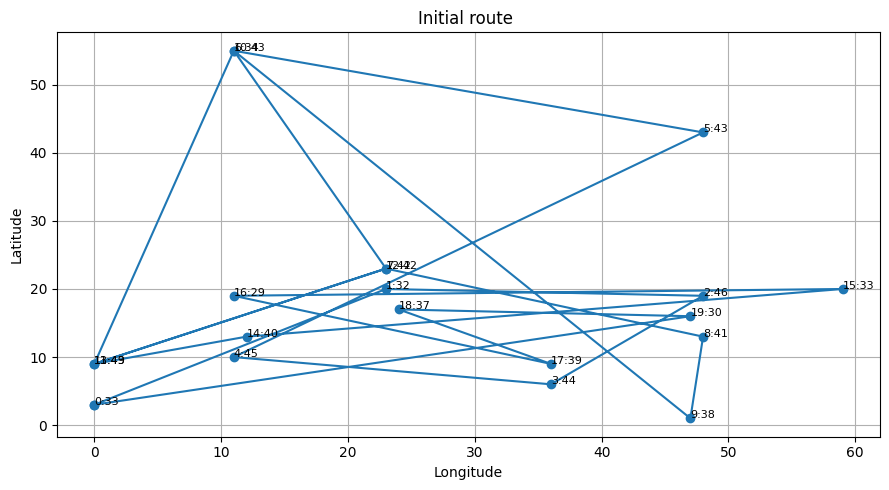

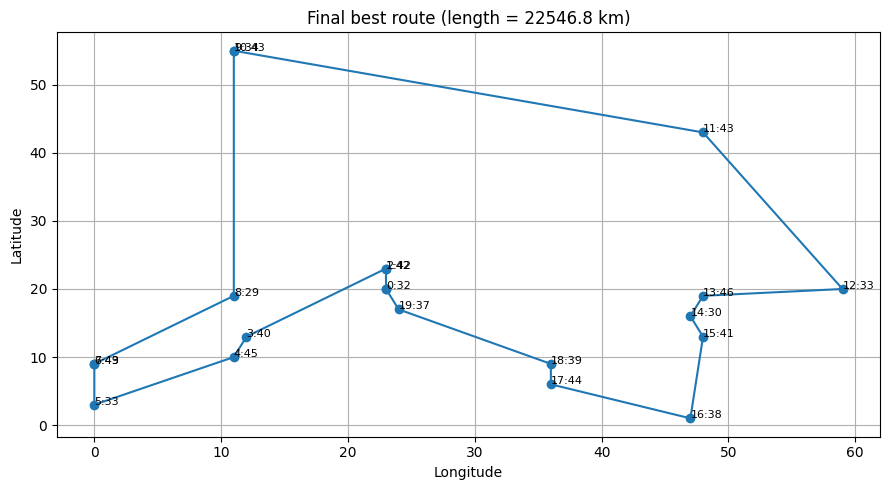

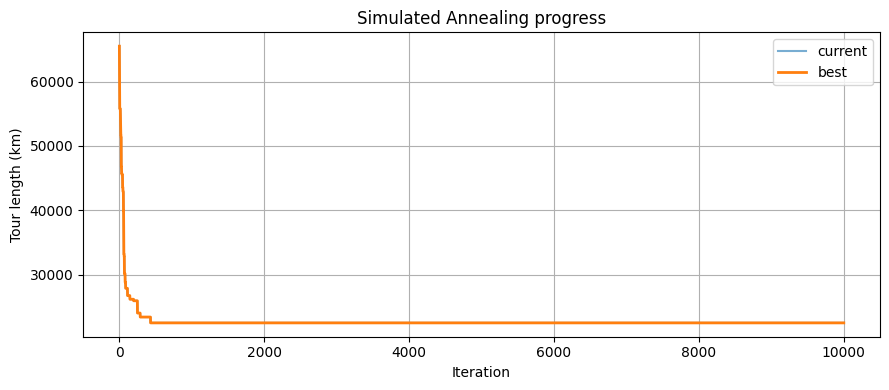


Final visiting order (best):
 1. 32                              ( 20.0000,   23.0000)
 2. 42                              ( 23.0000,   23.0000)
 3. 42                              ( 23.0000,   23.0000)
 4. 40                              ( 13.0000,   12.0000)
 5. 45                              ( 10.0000,   11.0000)
 6. 33                              (  3.0000,    0.0000)
 7. 49                              (  9.0000,    0.0000)
 8. 43                              (  9.0000,    0.0000)
 9. 29                              ( 19.0000,   11.0000)
10. 34                              ( 55.0000,   11.0000)
11. 43                              ( 55.0000,   11.0000)
12. 43                              ( 43.0000,   48.0000)
13. 33                              ( 20.0000,   59.0000)
14. 46                              ( 19.0000,   48.0000)
15. 30                              ( 16.0000,   47.0000)
16. 41                              ( 13.0000,   48.0000)
17. 38                              (  1.0

In [31]:
import math, random, requests, io, pandas as pd, numpy as np, matplotlib.pyplot as plt

CITY_URL="https://people.sc.fsu.edu/~jburkardt/data/csv/cities.csv"
N_CITIES=20
RANDOM_SEED=42
MAX_ITER=10000
INITIAL_T=1.0
FINAL_T=1e-6
ALPHA=0.9995

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def haversine(lat1, lon1, lat2, lon2):
    R=6371.0
    phi1,phi2=math.radians(lat1),math.radians(lat2)
    dphi=math.radians(lat2-lat1)
    dlambda=math.radians(lon2-lon1)
    a=math.sin(dphi/2)**2+math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a),math.sqrt(1-a))

def compute_distance_matrix(coords):
    n=len(coords)
    D=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            d=haversine(coords[i][0],coords[i][1],coords[j][0],coords[j][1])
            D[i,j]=d; D[j,i]=d
    return D

def route_length(route,D):
    total=0.0
    for i in range(len(route)):
        a=route[i]; b=route[(i+1)%len(route)]
        total+=D[a,b]
    return total

def two_opt_swap(route,i,k):
    return route[:i]+route[i:k+1][::-1]+route[k+1:]

def load_cities_from_fsu(url=CITY_URL):
    r=requests.get(url,timeout=10); r.raise_for_status()
    text=r.text
    df=pd.read_csv(io.StringIO(text))
    dms_cols={"LatD","LatM","LatS","NS","LonD","LonM","LonS","EW"}
    if dms_cols.issubset(set(df.columns)):
        lat_deg=df["LatD"]+df["LatM"]/60.0+df["LatS"]/3600.0
        lon_deg=df["LonD"]+df["LonM"]/60.0+df["LonS"]/3600.0
        lon_deg=lon_deg*df["EW"].map({"E":1,"W":-1}).fillna(1)
        lat_deg=lat_deg*df["NS"].map({"N":1,"S":-1}).fillna(1)
        names=df["City"].astype(str).values
        return [{"name":names[i],"lat":float(lat_deg.iloc[i]),"lon":float(lon_deg.iloc[i])} for i in range(len(df))]
    numeric=df.apply(lambda col:pd.to_numeric(col,errors="coerce"))
    numeric_cols=[c for c in df.columns if pd.to_numeric(df[c],errors="coerce").notnull().sum()>0]
    if len(numeric_cols)<2:
        raise RuntimeError("Could not find lat/lon columns in downloaded dataset")
    lat=pd.to_numeric(df[numeric_cols[-2]],errors="coerce")
    lon=pd.to_numeric(df[numeric_cols[-1]],errors="coerce")
    mask=lat.notnull()&lon.notnull()
    cities=[]
    for i in range(len(lat)):
        if mask.iloc[i]:
            name=str(df.iloc[i,0]) if df.shape[1]>0 else f"City{i}"
            cities.append({"name":name,"lat":float(lat.iloc[i]),"lon":float(lon.iloc[i])})
    if len(cities)==0:
        raise RuntimeError("No valid city rows with numeric lat/lon found")
    return cities

cities_all=load_cities_from_fsu()
if len(cities_all)<N_CITIES:
    raise RuntimeError(f"Only {len(cities_all)} cities available, increase dataset or lower N_CITIES")
selected=random.sample(cities_all,N_CITIES)
names=[c["name"] for c in selected]
coords=[(c["lat"],c["lon"]) for c in selected]
D=compute_distance_matrix(coords)
n=N_CITIES
initial_route=list(range(n)); random.shuffle(initial_route)
current_route=initial_route[:]; best_route=current_route[:]
current_len=route_length(current_route,D); best_len=current_len
initial_route_saved=current_route[:]; initial_length=current_len
history=[]; best_history=[]
T=INITIAL_T

for iteration in range(MAX_ITER):
    i=random.randint(0,n-2); k=random.randint(i+1,n-1)
    candidate=two_opt_swap(current_route,i,k)
    cand_len=route_length(candidate,D)
    delta=cand_len-current_len
    if delta<0 or random.random()<math.exp(-delta/max(T,1e-12)):
        current_route=candidate; current_len=cand_len
    if current_len<best_len:
        best_len=current_len; best_route=current_route[:]
    history.append(current_len); best_history.append(best_len)
    T*=ALPHA
    if T<FINAL_T:
        break

def plot_tour(route,coords,title,names=None):
    lat=[coords[i][0] for i in route]+[coords[route[0]][0]]
    lon=[coords[i][1] for i in route]+[coords[route[0]][1]]
    plt.figure(figsize=(9,5)); plt.plot(lon,lat,'-o',markersize=6)
    for pos,idx in enumerate(route):
        plt.text(coords[idx][1],coords[idx][0],f"{pos}:{names[idx] if names else idx}",fontsize=8)
    plt.title(title); plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.grid(True); plt.tight_layout()

plot_tour(initial_route_saved,coords,f"Initial route ",names)
plot_tour(best_route,coords,f"Final best route (length = {best_len:.1f} km)",names)
plt.figure(figsize=(9,4)); plt.plot(history,label="current",alpha=0.6); plt.plot(best_history,label="best",linewidth=2)
plt.xlabel("Iteration"); plt.ylabel("Tour length (km)"); plt.legend(); plt.title("Simulated Annealing progress"); plt.grid(True); plt.tight_layout(); plt.show()

print("\nFinal visiting order (best):")
for pos,idx in enumerate(best_route):
    print(f"{pos+1:2d}. {names[idx]:30s}  ({coords[idx][0]:8.4f}, {coords[idx][1]:9.4f})")
print(f"\nInitial length: {initial_length:.2f} km")
print(f"Final best length: {best_len:.2f} km after {len(history)} iterations")
